In [30]:
# ============================================================
# 📦 Load All Final 2026 Forecast Files into One DataFrame
# ============================================================

import os
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame


# ---------------------------------------------------------------------
# 1️⃣ CONFIGURATION
# ---------------------------------------------------------------------
BASE_DIR = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"
FORECAST_YEAR = "2026"

food_categories = [
    "Bakery and cereal products (excluding baby food)",
    "Dairy products and eggs",
    "Fish, seafood and other marine products",
    "Food purchased from restaurants",
    "Food",
    "Fruit, fruit preparations and nuts",
    "Meat",
    "Other food products and non-alcoholic beverages",
    "Vegetables and vegetable preparations",
]

model_list = [
    "DeepAR",
    "TemporalFusionTransformer",
#     "Chronos",
    "SimpleFeedForward",
    "AutoETS",
    "ARIMA",
    "CovariatesDeepAR",
    "CovariatesTemporalFusionTransformer"
]

time_limit = 1800  # used in generation script, not required here


# ---------------------------------------------------------------------
# 2️⃣ FIND ALL FORECAST FILES
# ---------------------------------------------------------------------
def find_forecast_files(base_dir, forecast_year):
    forecast_files = []
    for root, _, files in os.walk(base_dir):
        if forecast_year in root:
            for f in files:
                if f.endswith("_forecasts.csv"):
                    forecast_files.append(os.path.join(root, f))
    return sorted(forecast_files)


files = find_forecast_files(BASE_DIR, FORECAST_YEAR)
print(f"Found {len(files)} forecast files")
if files:
    print("\nExample paths:")
    for f in files[:5]:
        print(" •", f)
else:
    print("⚠️ No forecast files found. Check your BASE_DIR or FORECAST_YEAR.")


# ---------------------------------------------------------------------
# 3️⃣ PARSE METADATA
# ---------------------------------------------------------------------
def parse_metadata(path):
    """
    Extract category and model name from file path:
    /.../<category>/<year>/<category>_<model>_forecasts.csv
    """
    parts = path.split(os.sep)
    category = parts[-3]
    fname = os.path.basename(path).replace(".csv", "")
    model_name = fname.replace(f"{category}_", "").replace("_forecasts", "")
    return category, model_name


# ---------------------------------------------------------------------
# 4️⃣ LOAD AND COMBINE INTO SINGLE DATAFRAME
# ---------------------------------------------------------------------
records = []
for path in files:
    try:
        cat, model = parse_metadata(path)
        df = pd.read_csv(path)
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df["category"] = cat
        df["model"] = model
        df["forecast_year"] = FORECAST_YEAR
        records.append(df)
    except Exception as e:
        print(f"⚠️ Error loading {path}: {e}")

if not records:
    raise ValueError("❌ No forecast files were loaded. Double-check paths.")

all_forecasts = pd.concat(records, ignore_index=True)
print(f"\n✅ Combined DataFrame shape: {all_forecasts.shape}")
display(all_forecasts.head())


# ---------------------------------------------------------------------
# 5️⃣ RESHAPE TO LONG FORM (ONE ROW PER QUANTILE)
# ---------------------------------------------------------------------
value_cols = [c for c in all_forecasts.columns if c.startswith("q_")]
long_forecasts = all_forecasts.melt(
    id_vars=["timestamp", "category", "model", "forecast_year"],
    value_vars=value_cols,
    var_name="quantile",
    value_name="value",
)
print(f"✅ Long-form DataFrame shape: {long_forecasts.shape}")
display(long_forecasts.head())


# ---------------------------------------------------------------------
# 6️⃣ SUMMARY CHECKS
# ---------------------------------------------------------------------
summary = long_forecasts.groupby(["category", "model"]).size().reset_index(name="num_points")
print("\n📊 Forecast count summary:")
display(summary.head(20))


# ---------------------------------------------------------------------
# 7️⃣ CHECK FOR MISSING FORECASTS BY CATEGORY/MODEL
# ---------------------------------------------------------------------
print("\n🔍 Missing forecasts per category/model:")
expected = {(cat, model) for cat in food_categories for model in model_list}
found = {(row.category, row.model) for _, row in summary.iterrows()}
missing = expected - found

if missing:
    for cat, model in sorted(missing):
        print(f" - Missing {model} forecast for {cat}")
else:
    print("✅ All expected forecasts present!")


# ---------------------------------------------------------------------
# 8️⃣ HELPER: GET FORECAST FOR CATEGORY/MODEL
# ---------------------------------------------------------------------
def get_forecast(category, model):
    return long_forecasts[
        (long_forecasts["category"] == category)
        & (long_forecasts["model"] == model)
    ]

# Example usage:
# bakery_deepar = get_forecast("Bakery and cereal products (excluding baby food)", "DeepAR")
# display(bakery_deepar.head())


Found 70 forecast files

Example paths:
 • /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_ARIMA_forecasts.csv
 • /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_AutoETS_forecasts.csv
 • /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
 • /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_CovariatesTemporalFusionTransformer_forecasts.csv
 • /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and 

,timestamp,q_0.5,q_0.05,q_0.95,category,model,forecast_year,q_0.01,q_0.1,q_0.25,q_0.75,q_0.9,q_0.99
0,2025-09-01,200.964465,198.822236,203.106693,Bakery and cereal products (excluding baby food),ARIMA,2026,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-01,201.892089,198.928180,204.855998,Bakery and cereal products (excluding baby food),ARIMA,2026,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-11-01,202.250541,198.515790,205.985291,Bakery and cereal products (excluding baby food),ARIMA,2026,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-12-01,202.443495,197.971242,206.915747,Bakery and cereal products (excluding baby food),ARIMA,2026,NaN,NaN,NaN,NaN,NaN,NaN
4,2026-01-01,204.459553,199.277502,209.641604,Bakery and cereal products (excluding baby food),ARIMA,2026,NaN,NaN,NaN,NaN,NaN,NaN


✅ Long-form DataFrame shape: (10080, 6)


,timestamp,category,model,forecast_year,quantile,value
0,2025-09-01,Bakery and cereal products (excluding baby food),ARIMA,2026,q_0.5,200.964465
1,2025-10-01,Bakery and cereal products (excluding baby food),ARIMA,2026,q_0.5,201.892089
2,2025-11-01,Bakery and cereal products (excluding baby food),ARIMA,2026,q_0.5,202.250541
3,2025-12-01,Bakery and cereal products (excluding baby food),ARIMA,2026,q_0.5,202.443495
4,2026-01-01,Bakery and cereal products (excluding baby food),ARIMA,2026,q_0.5,204.459553



📊 Forecast count summary:


,category,model,num_points
0,Bakery and cereal products (excluding baby food),ARIMA,144
1,Bakery and cereal products (excluding baby food),AutoETS,144
2,Bakery and cereal products (excluding baby food),CovariatesDeepAR,144
3,Bakery and cereal products (excluding baby food),CovariatesTemporalFusionTransformer,144
4,Bakery and cereal products (excluding baby food),DeepAR,144
5,Bakery and cereal products (excluding baby food),SimpleFeedForward,144
6,Bakery and cereal products (excluding baby food),TemporalFusionTransformer,144
7,Bakery and cereal products (excluding baby food),WeightedEnsemble,144
8,Dairy products and eggs,ARIMA,144
9,Dairy products and eggs,AutoETS,144



🔍 Missing forecasts per category/model:
 - Missing ARIMA forecast for Food
 - Missing ARIMA forecast for Food purchased from restaurants


In [31]:
# =====================================================================
# 📊 PREDICTED YOY % CHANGE (2026 vs 2025) — FIXED FOR INDEX DATE
# =====================================================================

import pandas as pd
import numpy as np

# Ground truth CPI data (actuals through 2025)
csv_path = "/h/kupfersk/cfpr_2026/data_limited_2026/CFPR_2026_master_dataset.csv"

# ✅ Load with index as datetime
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df = df.sort_index()
print(f"✅ Loaded CPI dataset with shape {df.shape} and index name: {df.index.name}")

# Compute mean CPI (Jan–Sep 2025)
mean_2025 = df.loc["2025-01-01":"2025-09-01"].mean()
mean_2025.name = "Mean 2025 CPI (Jan–Sep)"

records = []

for category in food_categories:
    for model in model_list:
        # Filter forecast data (median quantile)
        sub = long_forecasts[
            (long_forecasts["category"] == category)
            & (long_forecasts["model"] == model)
            & (long_forecasts["quantile"] == "q_0.5")
        ].copy()

        if sub.empty:
            print(f"⚠️ Missing forecast for {category} ({model})")
            continue

        sub = sub.set_index("timestamp").sort_index()

        # Predicted mean CPI for Jan–Sep 2026
        pred_2026_mean = sub.loc["2026-01-01":"2026-09-01", "value"].mean()

        # Actual mean CPI for Jan–Sep 2025
        ref_2025_mean = mean_2025.get(category, np.nan)

        if pd.isna(pred_2026_mean) or pd.isna(ref_2025_mean):
            continue

        # Predicted YoY % change
        yoy_change = (pred_2026_mean - ref_2025_mean) / ref_2025_mean * 100

        records.append({
            "Category": category,
            "Model": model,
            "Mean 2025 CPI (Jan–Sep)": round(ref_2025_mean, 2),
            "Predicted 2026 CPI (Jan–Sep)": round(pred_2026_mean, 2),
            "Predicted YoY % Change": round(yoy_change, 2),
        })

# Combine and sort
forecast_summary = pd.DataFrame(records).sort_values(["Category", "Model"]).reset_index(drop=True)

print("\n✅ Predicted YoY % Change Summary (2026 vs 2025):")
display(forecast_summary)

# Save summary table
forecast_summary.to_csv(
    "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/predicted_yoy_summary.csv",
    index=False
)
print("💾 Saved → predicted_yoy_summary.csv")


✅ Loaded CPI dataset with shape (476, 13) and index name: date
⚠️ Missing forecast for Food purchased from restaurants (ARIMA)
⚠️ Missing forecast for Food (ARIMA)

✅ Predicted YoY % Change Summary (2026 vs 2025):


,Category,Model,Mean 2025 CPI (Jan–Sep),Predicted 2026 CPI (Jan–Sep),Predicted YoY % Change
0,Bakery and cereal products (excluding baby food),ARIMA,199.10,204.91,2.92
1,Bakery and cereal products (excluding baby food),AutoETS,199.10,201.67,1.29
2,Bakery and cereal products (excluding baby food),CovariatesDeepAR,199.10,201.22,1.06
3,Bakery and cereal products (excluding baby food),CovariatesTemporalFusionTransformer,199.10,208.39,4.66
4,Bakery and cereal products (excluding baby food),DeepAR,199.10,202.18,1.55
...,...,...,...,...,...
56,Vegetables and vegetable preparations,CovariatesDeepAR,193.18,193.54,0.19
57,Vegetables and vegetable preparations,CovariatesTemporalFusionTransformer,193.18,201.89,4.51
58,Vegetables and vegetable preparations,DeepAR,193.18,202.57,4.86
59,Vegetables and vegetable preparations,SimpleFeedForward,193.18,200.42,3.75


💾 Saved → predicted_yoy_summary.csv



📈 Plotting category: Bakery and cereal products (excluding baby food)
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Bakery and cereal products (excluding baby food)_Forecasts.png


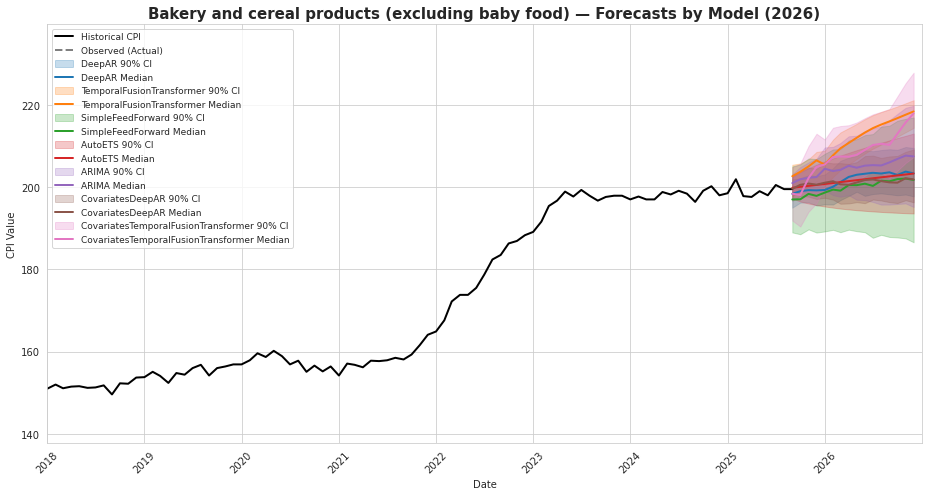


📈 Plotting category: Dairy products and eggs
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Dairy products and eggs_Forecasts.png


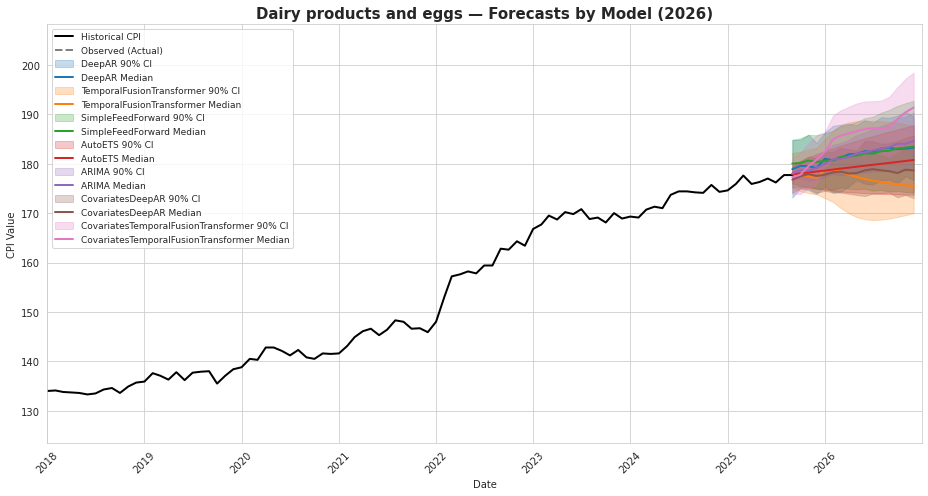


📈 Plotting category: Fish, seafood and other marine products
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Fish, seafood and other marine products_Forecasts.png


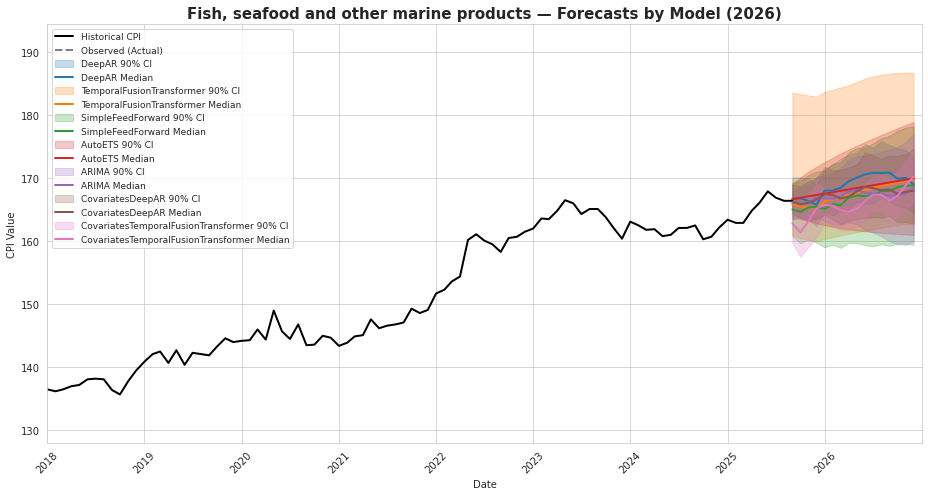


📈 Plotting category: Food purchased from restaurants
⚠️ No forecast for Food purchased from restaurants (ARIMA)
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Food purchased from restaurants_Forecasts.png


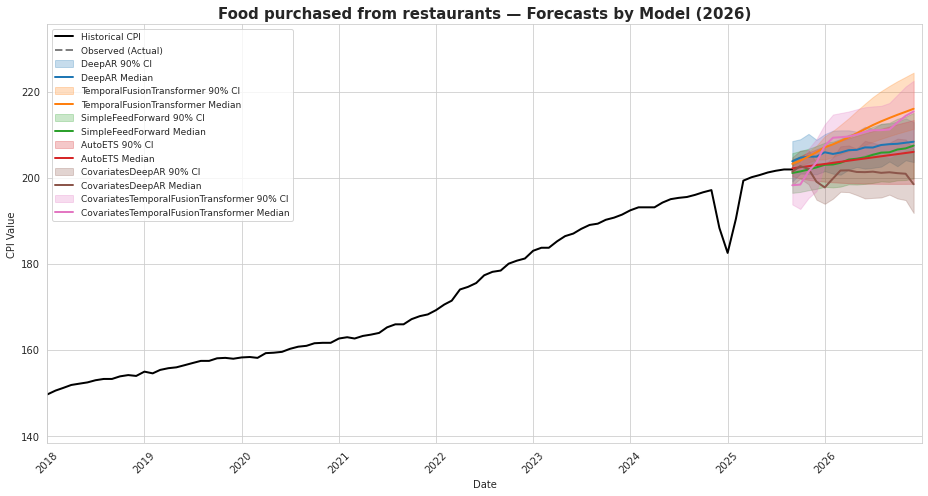


📈 Plotting category: Food
⚠️ No forecast for Food (ARIMA)
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Food_Forecasts.png


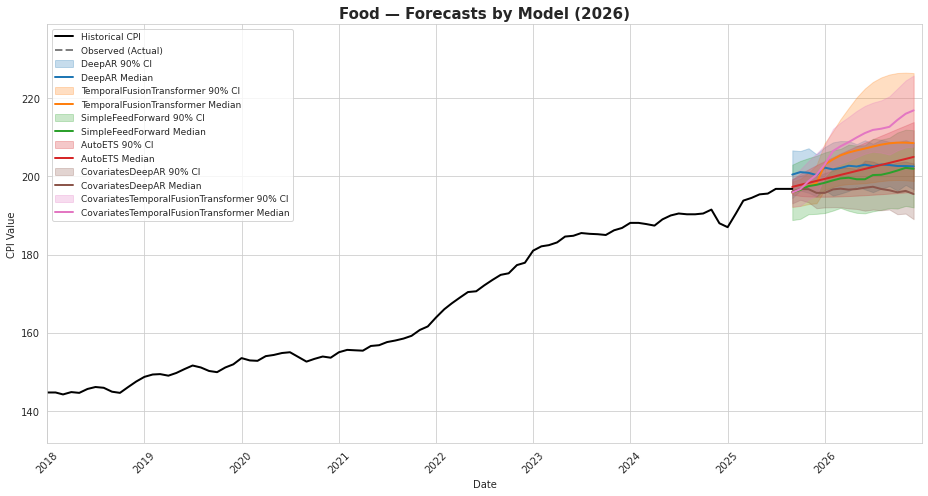


📈 Plotting category: Fruit, fruit preparations and nuts
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Fruit, fruit preparations and nuts_Forecasts.png


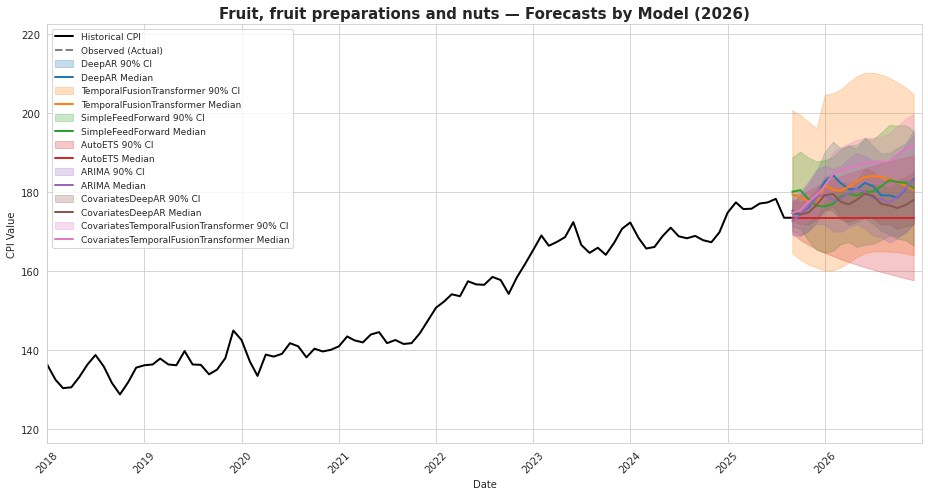


📈 Plotting category: Meat
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_from_df/Meat_Forecasts.png


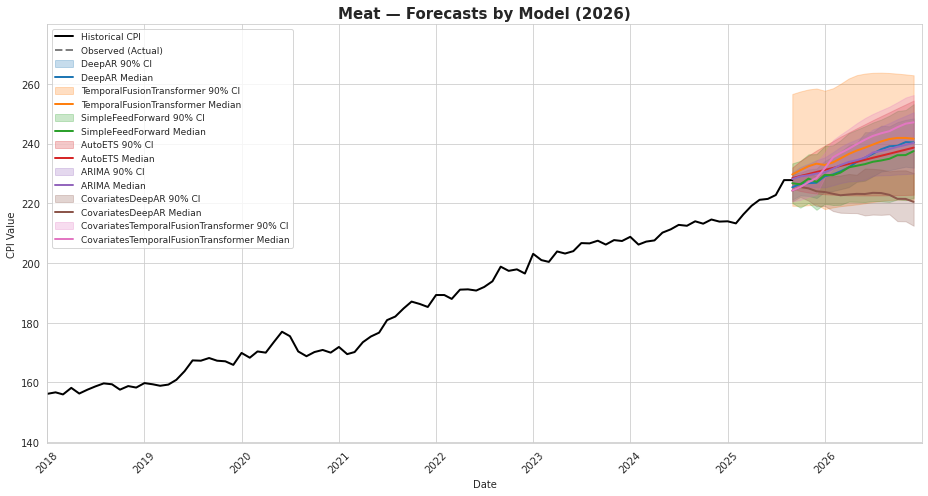

In [ ]:
# ============================================================
# 📊 PLOT ALL FINAL FORECASTS USING LOADED FORECAST DATAFRAME
# ============================================================

plot_final_forecasts_from_df(
    ts_df=ts_df,                     # from your master dataset
    long_forecasts=long_forecasts,   # loaded above
    food_categories=food_categories, # defined earlier
    model_list=model_list,           # list of models to include
    output_dir=BASE_DIR,             # same folder
    show_plots=True,                 # show inline
    save_plots=True,                 # also save PNGs
    start_year=2018,                 # start of historical context
    forecast_year="2026"             # label in title
)


In [ ]:
# =====================================================================
# 🧮 ENSEMBLE FORECAST (2026 vs 2025) WITH CONFIDENCE INTERVALS
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Ground truth CPI data
csv_path = "/h/kupfersk/cfpr_2026/data_limited_2026/CFPR_2026_master_dataset.csv"
df_actual = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df_actual = df_actual.sort_index()

# Mean 2025 CPI for Jan–Sep
mean_2025 = df_actual.loc["2025-01-01":"2025-09-01"].mean()
mean_2025.name = "Mean 2025 CPI (Jan–Sep)"

ensemble_records = []
ensemble_series = {}

for category in food_categories:
    print(f"\n📦 Building ensemble for: {category}")

    # Mean 2025 actual CPI
    ref_2025_mean = mean_2025.get(category, np.nan)
    if pd.isna(ref_2025_mean):
        print(f"⚠️ Missing 2025 data for {category}")
        continue

    # Extract all model forecasts for category
    cat_forecasts = long_forecasts[
        (long_forecasts["category"] == category) &
        (long_forecasts["quantile"] == "q_0.5")
    ].copy()

    if cat_forecasts.empty:
        print(f"⚠️ No forecasts for {category}")
        continue

    # Group by timestamp to average across models
    cat_pivot = (
        cat_forecasts
        .groupby("timestamp")["value"]
        .agg(["mean", "std"])
        .rename(columns={"mean": "ensemble_mean", "std": "ensemble_std"})
    )

    # Restrict to forecast window (Jan–Sep 2026)
    sub_2026 = cat_pivot.loc["2026-01-01":"2026-09-01"]

    pred_2026_mean = sub_2026["ensemble_mean"].mean()
    pred_2026_std = sub_2026["ensemble_mean"].std()

    # Ensemble YoY % change ± std
    yoy_mean = (pred_2026_mean - ref_2025_mean) / ref_2025_mean * 100
    yoy_std = pred_2026_std / ref_2025_mean * 100

    ensemble_records.append({
        "Category": category,
        "Mean 2025 CPI (Jan–Sep)": round(ref_2025_mean, 2),
        "Ensemble 2026 CPI (Jan–Sep)": round(pred_2026_mean, 2),
        "Predicted YoY % Change (mean)": round(yoy_mean, 2),
        "Predicted YoY % Change (±1σ)": round(yoy_std, 2),
        "Predicted YoY % Range (mean ± 1σ)": f"{round(yoy_mean - yoy_std, 2)} to {round(yoy_mean + yoy_std, 2)}",
    })

    # Save ensemble series for plotting
    ensemble_series[category] = cat_pivot


# Combine summary table
ensemble_summary = pd.DataFrame(ensemble_records)
print("\n✅ Ensemble YoY Summary (2026 vs 2025):")
display(ensemble_summary)

# Save summary to CSV
ensemble_summary.to_csv(
    "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/ensemble_yoy_summary.csv",
    index=False
)
print("💾 Saved → ensemble_yoy_summary.csv")


# =====================================================================
# 📈 PLOT ENSEMBLE FORECASTS (WITH


In [ ]:

# =====================================================================
# 📈 PLOT ENSEMBLE FORECASTS (WITH 95% CONFIDENCE INTERVALS)
# =====================================================================
plot_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/ensemble_plots"
os.makedirs(plot_dir, exist_ok=True)

for category in food_categories:
    if category not in ensemble_series:
        continue

    print(f"📊 Plotting ensemble for {category}")
    ens_df = ensemble_series[category].copy()
    ens_df.index = pd.to_datetime(ens_df.index)

    # Compute 95% CI
    ens_df["upper_95"] = ens_df["ensemble_mean"] + 1.96 * ens_df["ensemble_std"]
    ens_df["lower_95"] = ens_df["ensemble_mean"] - 1.96 * ens_df["ensemble_std"]

    # Historical data (2018–2025)
    hist = df_actual[category]
    hist = hist.loc["2018-01-01":"2025-09-01"]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist.values, color="black", linewidth=2, label="Historical CPI (Actual)")
    plt.plot(ens_df.index, ens_df["ensemble_mean"], color="tab:blue", linewidth=2, label="Ensemble Mean (2026)")
    plt.fill_between(
        ens_df.index,
        ens_df["lower_95"],
        ens_df["upper_95"],
        color="tab:blue",
        alpha=0.2,
        label="95% Confidence Interval",
    )

    plt.title(f"{category} — Ensemble Forecast (2026)", fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("CPI Value")
    plt.legend(loc="upper left", fontsize=9)
    plt.xlim(pd.Timestamp("2018-01-01"), pd.Timestamp("2026-12-31"))
    plt.tight_layout()

    save_path = os.path.join(plot_dir, f"{category.replace('/', '_')}_ensemble_forecast.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"💾 Saved → {save_path}")

print("\n✅ Ensemble forecasts plotted and saved for all categories.")

In [ ]:
# # ======================================================================
# # 🩹 FIX ARIMA FORECAST DATES (Shift timestamps back by one month)
# # ======================================================================

# import os
# import pandas as pd
# from dateutil.relativedelta import relativedelta

# base_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"
# forecast_year = "2026"
# model_name = "ARIMA"

# # Get all category folders in the base directory
# category_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# for category_folder in category_dirs:
#     category_path = os.path.join(base_dir, category_folder, forecast_year)
#     if not os.path.exists(category_path):
#         continue

#     for file in os.listdir(category_path):
#         if not file.endswith(f"_{model_name}_forecasts.csv"):
#             continue

#         file_path = os.path.join(category_path, file)
#         print(f"\n🧭 Found ARIMA file: {file_path}")

#         # Load forecast CSV
#         df = pd.read_csv(file_path)

#         # Identify the correct timestamp column
#         date_col = "DATE" if "DATE" in df.columns else "timestamp" if "timestamp" in df.columns else None
#         if date_col is None:
#             print(f"⚠️ Skipping {file_path}: no DATE or timestamp column found.")
#             continue

#         # Convert to datetime safely
#         df["timestamp"] = pd.to_datetime(df[date_col], errors="coerce")
#         if df["timestamp"].isna().all():
#             print(f"⚠️ Could not parse timestamps in {file_path}.")
#             continue

#         # Show before shift
#         print("🕓 Before shift:", df["timestamp"].head(3).tolist())

#         # Shift all timestamps back by 1 month
#         df["timestamp"] = df["timestamp"].apply(lambda x: x - relativedelta(months=1))

#         # Show after shift
#         print("✅ After shift:", df["timestamp"].head(3).tolist())

#         # Drop old DATE column (keep standardized "timestamp")
#         if "DATE" in df.columns:
#             df = df.drop(columns=["DATE"])

#         # Move timestamp to front for consistency
#         cols = ["timestamp"] + [c for c in df.columns if c != "timestamp"]
#         df = df[cols]

#         # Save a backup
#         backup_path = file_path.replace(".csv", "_backup.csv")
#         df.to_csv(backup_path, index=False)
#         print(f"💾 Backup saved → {backup_path}")

#         # Overwrite corrected file
#         df.to_csv(file_path, index=False)
#         print(f"✅ Fixed and overwritten → {file_path}")

# print("\n🎉 All ARIMA forecast timestamps have been shifted back by one month!")
